In [2]:
# Imports
import copy

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

import time
import torch
import torchvision
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm

# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")
plt.rc('axes', unicode_minus=False)

# @title Helper functions
def print_params(model):
  """
  Lists the name and current value of the model's
  named parameters

  Args:
    model: an nn.Module inherited model
      Represents the ML/DL model

  Returns:
    Nothing
  """
  for name, param in model.named_parameters():
    if param.requires_grad:
      print(name, param.data)

# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call the `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Handles variability by controlling sources of randomness
  through set seed values

  Args:
    seed: Integer
      Set the seed value to given integer.
      If no seed, set seed value to random integer in the range 2^32
    seed_torch: Bool
      Seeds the random number generator for all devices to
      offer some guarantees on reproducibility

  Returns:
    Nothing
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules are used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.


In [4]:
# @title Download MNIST dataset
import tarfile, requests, os

fname = 'MNIST.tar.gz'
name = 'MNIST'
url = 'https://osf.io/y2fj6/download'

if not os.path.exists(name):
  print('\nDownloading MNIST dataset...')
  r = requests.get(url, allow_redirects=True)
  with open(fname, 'wb') as fh:
    fh.write(r.content)
  print('\nDownloading MNIST completed.')

if not os.path.exists(name):
  with tarfile.open(fname) as tar:
    tar.extractall()
    os.remove(fname)
else:
  print('MNIST dataset has been downloaded.')

def load_mnist_data(change_tensors=False, download=False):
  """
  Load training and test examples for the MNIST handwritten digits dataset
  with every image: 28*28 x 1 channel (greyscale image)

  Args:
    change_tensors: Bool
      Argument to check if tensors need to be normalised
    download: Bool
      Argument to check if dataset needs to be downloaded/already exists

  Returns:
    train_set:
      train_data: Tensor
        training input tensor of size (train_size x 784)
      train_target: Tensor
        training 0-9 integer label tensor of size (train_size)
    test_set:
      test_data: Tensor
        test input tensor of size (test_size x 784)
      test_target: Tensor
        training 0-9 integer label tensor of size (test_size)
  """
  # Load train and test sets
  train_set = datasets.MNIST(root='.', train=True, download=download,
                             transform=torchvision.transforms.ToTensor())
  test_set = datasets.MNIST(root='.', train=False, download=download,
                            transform=torchvision.transforms.ToTensor())

  # Original data is in range [0, 255]. We normalize the data wrt its mean and std_dev.
  # Note that we only used *training set* information to compute mean and std
  mean = train_set.data.float().mean()
  std = train_set.data.float().std()

  if change_tensors:
    # Apply normalization directly to the tensors containing the dataset
    train_set.data = (train_set.data.float() - mean) / std
    test_set.data = (test_set.data.float() - mean) / std
  else:
    tform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(mean=[mean / 255.], std=[std / 255.])
                                            ])
    train_set = datasets.MNIST(root='.', train=True, download=download,
                               transform=tform)
    test_set = datasets.MNIST(root='.', train=False, download=download,
                              transform=tform)

  return train_set, test_set


train_set, test_set = load_mnist_data(change_tensors=True)

In [10]:
# As we are just getting started, we will concentrate on a small subset of only 500 examples out of the 60.000 data points contained in the whole training set.

# Sample a random subset of 500 indices
subset_index = np.random.choice(len(train_set.data), 500)

# We will use these symbols to represent the training data and labels, to stay
# as close to the mathematical expressions as possible.
X, y = train_set.data[subset_index, :], train_set.targets[subset_index]

392000
392000


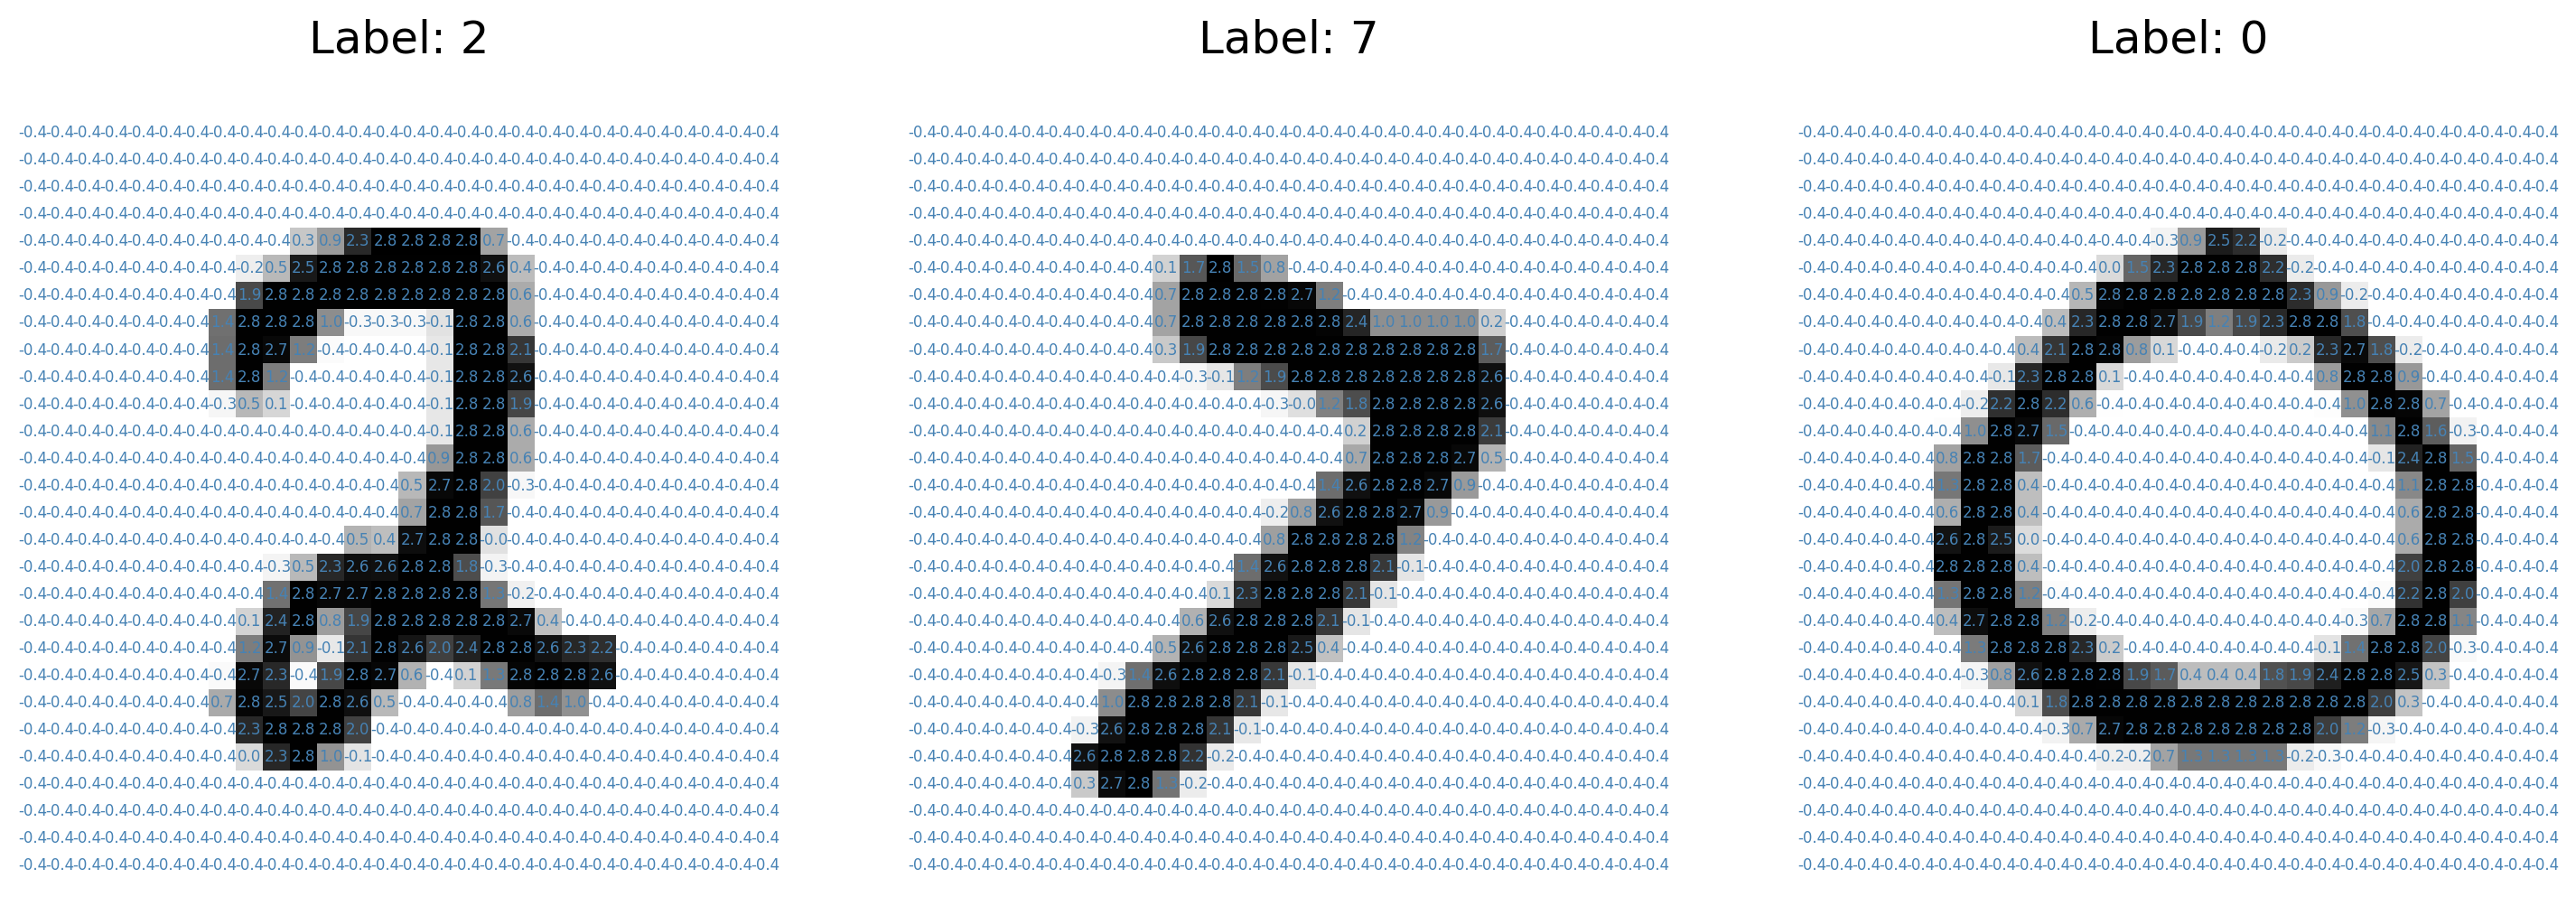

In [11]:
# Exploratory data analysis and visualisation

num_figures = 3
fig, axs = plt.subplots(1, num_figures, figsize=(5 * num_figures, 5))

for sample_id, ax in enumerate(axs):
  # Plot the pixel values for each image
  ax.matshow(X[sample_id, :], cmap='gray_r')
  # 'Write' the pixel value in the corresponding location
  for (i, j), z in np.ndenumerate(X[sample_id, :]):
    text = '{:.1f}'.format(z)
    ax.text(j, i, text, ha='center',
            va='center', fontsize=6, c='steelblue')

  ax.set_title('Label: ' + str(y[sample_id].item()))
  ax.axis('off')

plt.show()

## Model

As you will see next week, there are specific model architectures that are better suited to image-like data, such as Convolutional Neural Networks (CNNs). For simplicity, in this tutorial we will focus exclusively on Multi-Layer Perceptron (MLP) models as they allow us to highlight many important optimization challenges shared with more advanced neural network designs.

In [13]:
class MLP(nn.Module):
  """
  This class implements MLPs in Pytorch of an arbitrary number of hidden
  layers of potentially different sizes. Since we concentrate on classification
  tasks in this tutorial, we have a log_softmax layer at prediction time.
  """

  def __init__(self, in_dim=784, out_dim=10, hidden_dims=[], use_bias=True):
    """
    Constructs a MultiLayerPerceptron

    Args:
      in_dim: Integer
        dimensionality of input data (784)
      out_dim: Integer
        number of classes (10)
      hidden_dims: List
        containing the dimensions of the hidden layers,
        empty list corresponds to a linear model (in_dim, out_dim)

    Returns:
      Nothing
    """

    super(MLP, self).__init__()

    self.in_dim = in_dim
    self.out_dim = out_dim

    # If we have no hidden layer, just initialize a linear model (e.g. in logistic regression)
    if len(hidden_dims) == 0:
      layers = [nn.Linear(in_dim, out_dim, bias=use_bias)]
    else:
      # 'Actual' MLP with dimensions in_dim - num_hidden_layers*[hidden_dim] - out_dim
      layers = [nn.Linear(in_dim, hidden_dims[0], bias=use_bias), nn.ReLU()]

      # Loop until before the last layer
      for i, hidden_dim in enumerate(hidden_dims[:-1]):
        layers += [nn.Linear(hidden_dim, hidden_dims[i + 1], bias=use_bias),
                   nn.ReLU()]

      # Add final layer to the number of classes
      layers += [nn.Linear(hidden_dims[-1], out_dim, bias=use_bias)]

    self.main = nn.Sequential(*layers)

  def forward(self, x):
    """
    Defines the network structure and flow from input to output

    Args:
      x: Tensor
        Image to be processed by the network

    Returns:
      output: Tensor
        same dimension and shape as the input with probabilistic values in the range [0, 1]

    """
    # Flatten each images into a 'vector'
    transformed_x = x.view(-1, self.in_dim)
    hidden_output = self.main(transformed_x)
    output = F.log_softmax(hidden_output, dim=1)
    return output

In [14]:
# Empty hidden_dims means we take a model with zero hidden layers.
model = MLP(in_dim=784, out_dim=10, hidden_dims=[])

# We print the model structure with 784 inputs and 10 outputs
print(model)

MLP(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)


In [17]:
# In order to learn good parameters for this model, we will use the cross entropy loss (negative log-likelihood), which you saw in the last lecture, as a surrogate objective to be minimized.
# This particular choice of model and optimization objective leads to a convex optimization problem with respect to the parameters 𝑊 and 𝑏

loss_fn = F.nll_loss

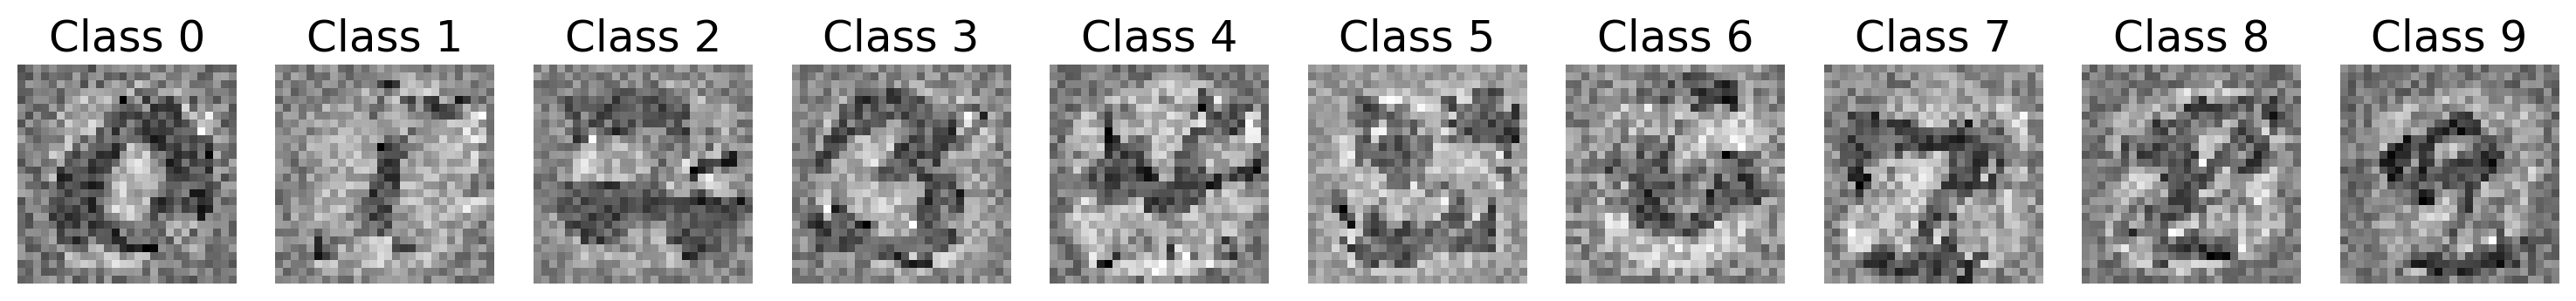

In [19]:
# In the last lecture, you saw that inspecting the weights of a model can provide insights on what ‘concepts’ the model has learned. Here we show the weights of a partially trained model. The weights corresponding to each class ‘learn’ to fire when an input of the class is detected.

cell_verbose = False
partial_trained_model = MLP(in_dim=784, out_dim=10, hidden_dims=[])

if cell_verbose:
  print('Init loss', loss_fn(partial_trained_model(X), y).item()) # This matches around np.log(10 = # of classes)

# Invoke an optimizer using Adaptive gradient and Momentum (more about this in Section 7)
optimizer = optim.Adam(partial_trained_model.parameters(), lr=7e-4)
for _ in range(200):
  loss = loss_fn(partial_trained_model(X), y)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

if cell_verbose:
  print('End loss', loss_fn(partial_trained_model(X), y).item()) # This should be less than 1e-2

# Show class filters of a trained model
W = partial_trained_model.main[0].weight.data.numpy()

fig, axs = plt.subplots(1, 10, figsize=(15, 4))
for class_id in range(10):
  axs[class_id].imshow(W[class_id, :].reshape(28, 28), cmap='gray_r')
  axs[class_id].axis('off')
  axs[class_id].set_title('Class ' + str(class_id) )

plt.show()

## High Dimensional Search

### Coding Exercise 3: Implement gradient descent

In [20]:
def zero_grad(params):
  """
  Clear gradients as they accumulate on successive backward calls

  Args:
    params: an iterator over tensors
      i.e., updating the Weights and biases

  Returns:
    Nothing
  """
  for par in params:
    if not(par.grad is None):
      par.grad.data.zero_()


def random_update(model, noise_scale=0.1, normalized=False):
  """
  Performs a random update on the parameters of the model to help
  understand the effectiveness of updating random directions
  for the problem of optimizing the parameters of a high-dimensional linear model.

  Args:
    model: nn.Module derived class
      The model whose parameters are to be updated

    noise_scale: float
      Specifies the magnitude of random weight

    normalized: Bool
      Indicates if the parameter has been normalised or not

  Returns:
    Nothing
  """
  for par in model.parameters():
    noise = torch.randn_like(par)
    if normalized:
      noise /= torch.norm(noise)
    par.data +=  noise_scale * noise

# Let’s implement the gradient descent!

def gradient_update(loss, params, lr=1e-3):
  """
  Perform a gradient descent update on a given loss over a collection of parameters

  Args:
    loss: Tensor
      A scalar tensor containing the loss through which the gradient will be computed
    params: List of iterables
      Collection of parameters with respect to which we compute gradients
    lr: Float
      Scalar specifying the learning rate or step-size for the update

  Returns:
    Nothing
  """
  # Clear up gradients as Pytorch automatically accumulates gradients from
  # successive backward calls
  zero_grad(params)

  # Compute gradients on given objective
  loss.backward()

  with torch.no_grad():
    for par in params:
      par.data -= lr * par.grad.data 


set_seed(seed=SEED)
model1 = MLP(in_dim=784, out_dim=10, hidden_dims=[])
print('\n The model1 parameters before the update are: \n')
print_params(model1)
loss = loss_fn(model1(X), y)

## Uncomment below to test your function
gradient_update(loss, list(model1.parameters()), lr=1e-1)
print('\n The model1 parameters after the update are: \n')
print_params(model1)


Random seed 2021 has been set.

 The model1 parameters before the update are: 

main.0.weight tensor([[-0.0264,  0.0010,  0.0173,  ...,  0.0297,  0.0278, -0.0221],
        [-0.0040, -0.0295, -0.0086,  ..., -0.0070,  0.0254, -0.0233],
        [ 0.0240, -0.0231,  0.0342,  ...,  0.0124,  0.0270, -0.0180],
        ...,
        [-0.0005,  0.0157,  0.0111,  ...,  0.0144, -0.0301, -0.0144],
        [ 0.0181,  0.0303,  0.0255,  ..., -0.0110, -0.0175,  0.0205],
        [ 0.0208, -0.0353, -0.0183,  ..., -0.0271,  0.0099,  0.0003]])
main.0.bias tensor([-0.0290, -0.0033,  0.0100, -0.0320,  0.0022,  0.0221,  0.0307,  0.0243,
         0.0159, -0.0064])

 The model1 parameters after the update are: 

main.0.weight tensor([[-0.0270,  0.0004,  0.0168,  ...,  0.0292,  0.0272, -0.0227],
        [-0.0060, -0.0315, -0.0106,  ..., -0.0090,  0.0235, -0.0253],
        [ 0.0240, -0.0231,  0.0341,  ...,  0.0123,  0.0269, -0.0181],
        ...,
        [-0.0009,  0.0154,  0.0107,  ...,  0.0140, -0.0304, -0.0147]

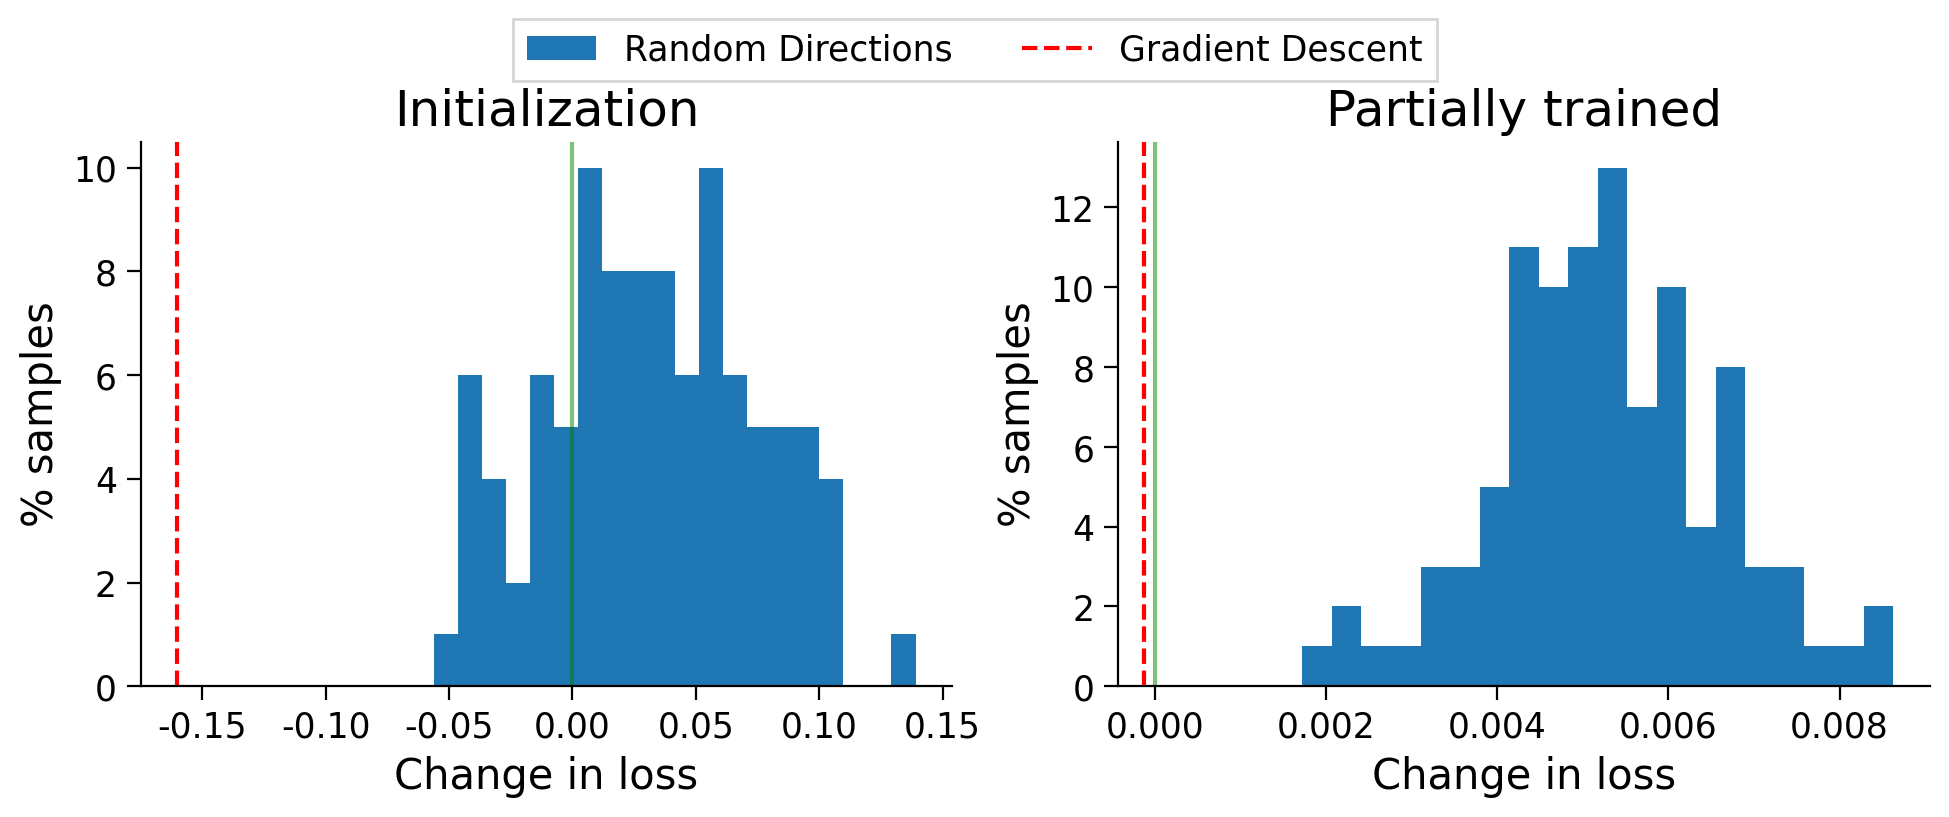

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for id, (model_name, my_model) in enumerate([('Initialization', model),
                                              ('Partially trained', partial_trained_model)]):
  # Compute the loss we will be comparing to
  base_loss = loss_fn(my_model(X), y)

  # Compute the improvement via gradient descent
  dummy_model = copy.deepcopy(my_model)
  loss1 = loss_fn(dummy_model(X), y)
  gradient_update(loss1, list(dummy_model.parameters()), lr=1e-2)
  gd_delta = loss_fn(dummy_model(X), y) - base_loss

  deltas = []
  for trial_id in range(100):
    # Compute the improvement obtained with a random direction
    dummy_model = copy.deepcopy(my_model)
    random_update(dummy_model, noise_scale=1e-2)
    deltas.append((loss_fn(dummy_model(X), y) - base_loss).item())

  # Plot histogram for random direction and vertical line for gradient descent
  axs[id].hist(deltas, label='Random Directions', bins=20)
  axs[id].set_title(model_name)
  axs[id].set_xlabel('Change in loss')
  axs[id].set_ylabel('% samples')
  axs[id].axvline(0, c='green', alpha=0.5)
  axs[id].axvline(gd_delta.item(), linestyle='--', c='red', alpha=1,
                  label='Gradient Descent')


handles, labels = axs[id].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',
           bbox_to_anchor=(0.5, 1.05),
           fancybox=False, shadow=False, ncol=2)

plt.show()

## Poor Conditioning

Discussion of momentum in [this video](https://youtu.be/3ES5O58Y_2M).

Things become complicated in multiple dimensions, because a high dimensional objective can have both low and high curvatures at the same time.. making problems for any particular step size.  We might want a large step size for one direction, and a small step size for another.

**Momentum** accelerates our progress along flat directions, and slow us down along sharp directions.  This modified gradient descent algorithm carries over the previous step, only smaller.

### Coding Exercise 4: Implement momentum

In this exercise you will implement the momentum update given by:

$$
w_{t+1}=w_t-\eta \nabla J\left(w_t\right)+\beta\left(w_t-w_{t-1}\right)
$$

It is convenient to re-express this update rule in terms of a recursion. For that, we define ‘velocity’ as the quantity:

$$
v_{t-1}:=w_t-w_{t-1}
$$

which leads to the two-step update rule:

$$
\begin{gathered}
v_t=-\eta \nabla J\left(w_t\right)+\beta(\underbrace{w_t-w_{t-1}}_{v_{t-1}}) \\
w_{t+1} \leftarrow w_t+v_t
\end{gathered}
$$

In [22]:
def momentum_update(loss, params, grad_vel, lr=1e-3, beta=0.8):
  """
  Perform a momentum update over a collection of parameters given a loss and velocities

  Args:
    loss: Tensor
      A scalar tensor containing the loss through which gradient will be computed
    params: Iterable
      Collection of parameters with respect to which we compute gradients
    grad_vel: Iterable
      Collection containing the 'velocity' v_t for each parameter
    lr: Float
      Scalar specifying the learning rate or step-size for the update
    beta: Float
      Scalar 'momentum' parameter

  Returns:
    Nothing
  """
  # Clear up gradients as Pytorch automatically accumulates gradients from
  # successive backward calls
  zero_grad(params)
  # Compute gradients on given objective
  loss.backward()

  with torch.no_grad():
    for (par, vel) in zip(params, grad_vel):
      # Update 'velocity'
      vel.data = -lr * par.grad.data + beta * vel.data
      # Update parameters
      par.data += vel.data


set_seed(seed=SEED)
model2 = MLP(in_dim=784, out_dim=10, hidden_dims=[])
print('\n The model2 parameters before the update are: \n')
print_params(model2)
loss = loss_fn(model2(X), y)
initial_vel = [torch.randn_like(p) for p in model2.parameters()]

## Uncomment below to test your function
momentum_update(loss, list(model2.parameters()), grad_vel=initial_vel, lr=1e-1, beta=0.9)
print('\n The model2 parameters after the update are: \n')
print_params(model2)

Random seed 2021 has been set.

 The model2 parameters before the update are: 

main.0.weight tensor([[-0.0264,  0.0010,  0.0173,  ...,  0.0297,  0.0278, -0.0221],
        [-0.0040, -0.0295, -0.0086,  ..., -0.0070,  0.0254, -0.0233],
        [ 0.0240, -0.0231,  0.0342,  ...,  0.0124,  0.0270, -0.0180],
        ...,
        [-0.0005,  0.0157,  0.0111,  ...,  0.0144, -0.0301, -0.0144],
        [ 0.0181,  0.0303,  0.0255,  ..., -0.0110, -0.0175,  0.0205],
        [ 0.0208, -0.0353, -0.0183,  ..., -0.0271,  0.0099,  0.0003]])
main.0.bias tensor([-0.0290, -0.0033,  0.0100, -0.0320,  0.0022,  0.0221,  0.0307,  0.0243,
         0.0159, -0.0064])

 The model2 parameters after the update are: 

main.0.weight tensor([[ 1.5892,  0.0109, -2.0246,  ..., -1.0877,  0.4024, -0.9583],
        [ 0.4640,  0.6009, -0.7376,  ...,  0.5472, -0.2760, -0.6553],
        [-1.4111, -1.1039,  0.6498,  ..., -1.0195,  0.6509,  0.1315],
        ...,
        [-0.5101,  0.5072, -0.0721,  ...,  1.1190,  0.2898, -0.9660]

## Non-convexivity

### Overparameterization

Are all models equally sensitive to initialization? No! Wider networks are less sensitive/easier to train.  There is ample empirical and theoretical evidence for this.

Increasing the network's parameters can have negative effects.  Overfitting: surprisingly, in many cases it doesn't occur.  Increased memory and computational complexity.

In [26]:
# @markdown Execute this cell to enable the widget!

@widgets.interact_manual
def overparam(max_steps=widgets.IntSlider(150, 50, 500, 5),
              hidden_dims=widgets.Dropdown(options=["10", "20, 20", "100, 100"],
                                           value="10"),
              lr=widgets.FloatLogSlider(value=5e-2, min=-3, max=0, step=0.1),
              num_inits=widgets.IntSlider(7, 5, 10, 1)):
  """
  Displays the overparameterization phenomenon as a widget

  Args:
    max_steps: widget integer slider
      Maximum number of steps on the slider with default = 150
    hidden_dims: widget dropdown menu instance
      The number of hidden dimensions with default = 10
    lr: widget float slider
      Scalar specifying the learning rate or step-size for the update with default = 5e-2
    num_inits: widget integer slider
      Scalar number of epochs

  Returns:
    Nothing
  """

  X, y = train_set.data[subset_index, :], train_set.targets[subset_index]

  hdims = [int(s) for s in hidden_dims.split(',')]
  base_model = MLP(in_dim=784, out_dim=10, hidden_dims=hdims)

  fig, axs = plt.subplots(1, 1, figsize=(5, 4))

  for _ in tqdm(range(num_inits)):
    model = copy.deepcopy(base_model)
    random_update(model, noise_scale=2e-1)
    loss_hist = np.zeros((max_steps, 2))
    for step in range(max_steps):
      loss = loss_fn(model(X), y)
      gradient_update(loss, list(model.parameters()), lr=lr)
      loss_hist[step] = np.array([step, loss.item()])

    plt.plot(loss_hist[:, 0], loss_hist[:, 1])

  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.ylim(0, 3)
  plt.show()

  num_params = sum([np.prod(_.shape) for _ in model.parameters()])
  print('Number of parameters in model:  ' + str(num_params))

interactive(children=(IntSlider(value=150, description='max_steps', max=500, min=50, step=5), Dropdown(descrip…

## Full Gradients are expensive

### Mini-batches

In big networks, computing the gradient for one example is costly.  The gradient for the full training set (aka full batch) is $n$ times that.  Do we really need to see all $n$ examples to do one single step?

For example, computing over 60k examples on MNIST for a single exact update is too expensive.  Even worse for bigger data sets.

We use **mini-batches**, subsets fo the training set.  Different at each step $t$.  Noisy estimate of the true gradient.. Stochastic gradients.

Some people say it's only SGD with batch size of 1 (and calling the batch method batch gradient descent), while others say its stochastic SGD if you're batching.  This explains my earlier confusion.

With batching, the gradient updates are worse (less accurate).  We can do many of them in the same time as a one full gradient step, which is good for speed.  We might not find the same minimum, but usually fine in practice.  

We select batches at random or after shuffling to make sure there are no order effects from the distribution.

How should we choose the batch size?  Too small of a batch: bounces around a lot, and can lead to slower convergence to a minimum.  Too big of a batch won't fit on the GPU.  Simple rule of thumb: Pick the largest batch size that fits in the GPU.

### Coding Exercise 6: Implement minibatch sampling


In [31]:
def sample_minibatch(input_data, target_data, num_points=100):
  """
  Sample a minibatch of size num_point from the provided input-target data

  Args:
    input_data: Tensor
      Multi-dimensional tensor containing the input data
    target_data: Tensor
      1D tensor containing the class labels
    num_points: Integer
      Number of elements to be included in minibatch with default=100

  Returns:
    batch_inputs: Tensor
      Minibatch inputs
    batch_targets: Tensor
      Minibatch targets
  """
  # Sample a collection of IID indices from the existing data
  batch_indices = np.random.choice(len(input_data), num_points)
  # Use batch_indices to extract entries from the input and target data tensors
  batch_inputs = input_data[batch_indices]
  batch_targets = target_data[batch_indices]

  return batch_inputs, batch_targets



## Uncomment to test your function
x_batch, y_batch = sample_minibatch(X, y, num_points=100)
print(f"The input shape is {x_batch.shape} and the target shape is: {y_batch.shape}")

The input shape is torch.Size([100, 28, 28]) and the target shape is: torch.Size([100])


In [32]:
@widgets.interact_manual
def minibatch_experiment(batch_sizes='20, 250, 1000',
                         lrs='5e-3, 5e-3, 5e-3',
                         time_budget=widgets.Dropdown(options=["2.5", "5", "10"],
                                                      value="2.5")):
  """
  Demonstration of minibatch experiment

  Args:
    batch_sizes: String
      Size of minibatches
    lrs: String
      Different learning rates
    time_budget: widget dropdown instance
      Different time budgets with default=2.5s

  Returns:
    Nothing
  """
  batch_sizes = [int(s) for s in batch_sizes.split(',')]
  lrs = [float(s) for s in lrs.split(',')]

  LOSS_HIST = {_:[] for _ in batch_sizes}

  X, y = train_set.data, train_set.targets
  base_model = MLP(in_dim=784, out_dim=10, hidden_dims=[100, 100])

  for id, batch_size in enumerate(tqdm(batch_sizes)):
    start_time = time.time()
    # Create a new copy of the model for each batch size
    model = copy.deepcopy(base_model)
    params = list(model.parameters())
    lr = lrs[id]
    # Fixed budget per choice of batch size
    while (time.time() - start_time) < float(time_budget):
      data, labels = sample_minibatch(X, y, batch_size)
      loss = loss_fn(model(data), labels)
      gradient_update(loss, params, lr=lr)
      LOSS_HIST[batch_size].append([time.time() - start_time,
                                    loss.item()])

  fig, axs = plt.subplots(1, len(batch_sizes), figsize=(10, 3))
  for ax, batch_size in zip(axs, batch_sizes):
    plot_data = np.array(LOSS_HIST[batch_size])
    ax.plot(plot_data[:, 0], plot_data[:, 1], label=batch_size,
            alpha=0.8)
    ax.set_title('Batch size: ' + str(batch_size))
    ax.set_xlabel('Seconds')
    ax.set_ylabel('Loss')
  plt.show()

interactive(children=(Text(value='20, 250, 1000', continuous_update=False, description='batch_sizes'), Text(va…

This highlights the interplay between the minibatch size and the learning rate: when our minibatch is larger, we have a more confident estimator of the direction to move, and thus can afford a larger learning rate. On the other hand, extremely small minibatches are very fast computationally but are not representative of the data distribution and yield estimations of the gradient with high variance.

## Adaptive Methods

If you learn too fast, you see wild variations on your loss curve.  You converge towards solutions with huge weights or infinity/NaN values.

If you learn too slowly, convergence takes forever.

A partial solution: decrease the rate if your loss varies wildly, otherwise increase it.  

Many people have messed with **learning rate schedules** where eta varies as a function of time.  People have also messed with weight or layer-specific learning rates.

RMSProp is a varient of Adagrad.  Uses a moving average instead of sum used by Adagrad.  RMSprop is especially effective on non-convex objectives.  Adam optimization adds momentum to RMSProp +  a couple more tricks.  It's been extremely successful.  Adam is curently the most popular adaptive method used in deep learning.

### Coding Exercise: Implement RMSProp

In [33]:
def rmsprop_update(loss, params, grad_sq, lr=1e-3, alpha=0.8, epsilon=1e-8):
  """
  Perform an RMSprop update on a collection of parameters

  Args:
    loss: Tensor
      A scalar tensor containing the loss whose gradient will be computed
    params: Iterable
      Collection of parameters with respect to which we compute gradients
    grad_sq: Iterable
      Moving average of squared gradients
    lr: Float
      Scalar specifying the learning rate or step-size for the update
    alpha: Float
      Moving average parameter
    epsilon: Float
      quotient for numerical stability

  Returns:
    Nothing
  """
  # Clear up gradients as Pytorch automatically accumulates gradients from
  # successive backward calls
  zero_grad(params)
  # Compute gradients on given objective
  loss.backward()

  with torch.no_grad():
    for (par, gsq) in zip(params, grad_sq):
      # Update estimate of gradient variance
      gsq.data = (alpha * gsq.data)  + (1 - alpha) * (par.grad ** 2)
      # Update parameters
      par.data -=  lr * ((par.grad.data) / (gsq.data + epsilon) ** 0.5)




set_seed(seed=SEED)
model3 = MLP(in_dim=784, out_dim=10, hidden_dims=[])
print('\n The model3 parameters before the update are: \n')
print_params(model3)
loss = loss_fn(model3(X), y)
# Initialize the moving average of squared gradients
grad_sq = [1e-6*i for i in list(model3.parameters())]



## Uncomment below to test your function
rmsprop_update(loss, list(model3.parameters()), grad_sq=grad_sq, lr=1e-3)
print('\n The model3 parameters after the update are: \n')
print_params(model3)

Random seed 2021 has been set.

 The model3 parameters before the update are: 

main.0.weight tensor([[-0.0264,  0.0010,  0.0173,  ...,  0.0297,  0.0278, -0.0221],
        [-0.0040, -0.0295, -0.0086,  ..., -0.0070,  0.0254, -0.0233],
        [ 0.0240, -0.0231,  0.0342,  ...,  0.0124,  0.0270, -0.0180],
        ...,
        [-0.0005,  0.0157,  0.0111,  ...,  0.0144, -0.0301, -0.0144],
        [ 0.0181,  0.0303,  0.0255,  ..., -0.0110, -0.0175,  0.0205],
        [ 0.0208, -0.0353, -0.0183,  ..., -0.0271,  0.0099,  0.0003]])
main.0.bias tensor([-0.0290, -0.0033,  0.0100, -0.0320,  0.0022,  0.0221,  0.0307,  0.0243,
         0.0159, -0.0064])

 The model3 parameters after the update are: 

main.0.weight tensor([[-0.0286, -0.0013,  0.0151,  ...,  0.0275,  0.0255, -0.0243],
        [-0.0063, -0.0318, -0.0109,  ..., -0.0093,  0.0232, -0.0255],
        [ 0.0220, -0.0254,  0.0323,  ...,  0.0103,  0.0250, -0.0203],
        ...,
        [-0.0027,  0.0135,  0.0088,  ...,  0.0122, -0.0323, -0.0166]

In [34]:
X, y = train_set.data, train_set.targets

@widgets.interact_manual
def compare_optimizers(
    batch_size=(25, 250, 5),
    lr=widgets.FloatLogSlider(value=2e-3, min=-5, max=0),
    max_steps=(50, 500, 5)):
  """
  Demonstration to compare optimisers - stochastic gradient descent, momentum, RMSprop

  Args:
    batch_size: Tuple
      Size of minibatches
    lr: Float log slider instance
      Scalar specifying the learning rate or step-size for the update
    max_steps: Tuple
      Max number of step sizes for incrementing

  Returns:
    Nothing
  """
  SGD_DICT = [gradient_update, 'SGD', 'black', '-', {'lr': lr}]
  MOM_DICT = [momentum_update, 'Momentum', 'red', '--', {'lr': lr, 'beta': 0.9}]
  RMS_DICT = [rmsprop_update, 'RMSprop', 'fuchsia', '-', {'lr': lr, 'alpha': 0.8}]

  ALL_DICTS = [SGD_DICT, MOM_DICT, RMS_DICT]

  base_model = MLP(in_dim=784, out_dim=10, hidden_dims=[100, 100])

  LOSS_HIST = {}

  for opt_dict in tqdm(ALL_DICTS):
    update_fn, opt_name, color, lstyle, kwargs = opt_dict
    LOSS_HIST[opt_name] = []

    model = copy.deepcopy(base_model)
    params = list(model.parameters())

    if opt_name != 'SGD':
      aux_tensors = [torch.zeros_like(_) for _ in params]

    for step in range(max_steps):
      data, labels = sample_minibatch(X, y, batch_size)
      loss = loss_fn(model(data), labels)
      if opt_name == 'SGD':
        update_fn(loss, params, **kwargs)
      else:
        update_fn(loss, params, aux_tensors, **kwargs)
      LOSS_HIST[opt_name].append(loss.item())

  fig, axs = plt.subplots(1, len(ALL_DICTS), figsize=(9, 3))
  for ax, optim_dict in zip(axs, ALL_DICTS):
    opt_name = optim_dict[1]
    ax.plot(range(max_steps), LOSS_HIST[opt_name], alpha=0.8)
    ax.set_title(opt_name)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    ax.set_ylim(0, 2.5)
  plt.show()

interactive(children=(IntSlider(value=135, description='batch_size', max=250, min=25, step=5), FloatLogSlider(…